In [7]:
#This is the notebook to set and train the clusterer

PATH_TO_CLUSTERS = 'assets/USA_clusters_7.csv'
PATH_OUT = 'assets/'

In [4]:
import pandas as pd
import numpy as np
import pickle
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

from datamanager.DM_USA import DM_USA

In [5]:
"""load data from csv into DataManager"""
with open('assets/params.json', 'r') as f:
    json_sell_out_params = json.load(f)

data_manager=DM_USA()
data_manager.ad_hoc_USA(json_sell_out_params)
#SHAPE (17160, 14)

In [9]:
df = data_manager.get_df()

In [8]:
"""load clusters_Belgium.csv"""
clusters = pd.read_csv(PATH_TO_CLUSTERS)
clusters.shape
#SHAPE (234, 4)

(1522, 4)

In [10]:
"""merge clusters into dataset, (reduce dataset to [Category, Brand, Sub Category] that are in clusters)"""
df_merged = pd.merge(clusters, df, on=['Category', 'Brand', 'Sub Category'])
df_merged.shape
#SHAPE (9360, 15)

(318098, 15)

In [11]:
"""log Distribution and Price"""
df_merged['Distribution'] = np.array(map(np.log1p, df_merged['Distribution'].values))
df_merged['Price per volume'] = np.array(map(np.log1p, df_merged['Price per volume'].values))
#df_merged['Distribution'] = df_merged['Distribution'].apply(np.log1p)
#df_merged['Price per volume'] = df_merged['Price per volume'].apply(np.log1p)

In [12]:
"""add number of caregories, number of sub categories"""
df_brand_categ = df_merged.groupby(['Brand'])['Category'].agg(Number_of_Categories = "nunique").reset_index().rename(columns={'Number_of_Categories':'Number of Categories'})
df_merged = pd.merge(df_merged, df_brand_categ, on="Brand", how="left")


df_sub_cat = df_merged.groupby(['Brand', 'Category'])['Sub Category'].agg(Sub_Categories='nunique').reset_index().rename(columns={'Sub_Categories':'Number of Sub Categories'})
df_merged = pd.merge(df_merged, df_sub_cat, on=["Brand", 'Category'], how="left")

In [13]:
"""sub dataframe as groupby [Category, Sub Category, Brand]"""
df_sub = df_merged.groupby(['Category', 'Sub Category', 'Brand'], as_index=False)['Cluster', 'Number of Categories', 'Number of Sub Categories'].max()
df_sub.shape
#SHAPE (234, 6)

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_16072/3657165396.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_sub = df_merged.groupby(['Category', 'Sub Category', 'Brand'], as_index=False)['Cluster', 'Number of Categories', 'Number of Sub Categories'].max()


(1522, 6)

In [14]:
"""compute high level metrics for time series of Distribution and Price per volume : min, max, mean, std"""
Distribution = df_merged.groupby(['Category', 'Sub Category', 'Brand'], as_index=False)['Distribution'].agg(
    {'min Distribution':'min', 'max Distribution':'max', 'mean Distribution':'mean', 'std Distribution':'std'}
)


Price = df_merged.groupby(['Category', 'Sub Category', 'Brand'], as_index=False)['Price per volume'].agg(
    {'min Price':'min', 'max Price':'max', 'mean Price':'mean', 'std Price':'std'}
)

In [15]:
"""merge high level metrics into df_sub"""
df_sub = pd.merge(df_sub, Distribution, on=['Category', 'Sub Category', 'Brand'])

df_sub = pd.merge(df_sub, Price, on=['Category', 'Sub Category', 'Brand'])
df_sub.shape
#SHAPE (234, 14)

(1522, 14)

In [16]:
df_sub

,Category,Sub Category,Brand,Cluster,Number of Categories,Number of Sub Categories,min Distribution,max Distribution,mean Distribution,std Distribution,min Price,max Price,mean Price,std Price
0,CLASSIC SPREADS,CLASSIC SPREADS,1000 ISLANDS RIVER RAT CHEESE,4,3,1,0.002717,0.026038,0.012917,0.005076,2.195000,2.563410,2.502905,0.073939
1,CLASSIC SPREADS,CLASSIC SPREADS,AMISH COUNTRY,6,2,1,0.432225,0.879614,0.584620,0.081734,2.195687,2.456572,2.386366,0.040652
2,CLASSIC SPREADS,CLASSIC SPREADS,APPEL FARM QUARK,6,1,1,0.055242,0.171575,0.106467,0.023035,1.552458,1.863690,1.767229,0.032317
3,CLASSIC SPREADS,CLASSIC SPREADS,AURICCHIO,4,5,1,0.002909,1.532103,0.781290,0.432320,2.752527,3.339073,3.025957,0.103222
4,CLASSIC SPREADS,CLASSIC SPREADS,B L,6,2,1,0.035805,1.312691,0.899917,0.287954,2.087050,2.198746,2.158983,0.018248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1517,SNACKING COMBOS,CHEESE SNACKING COMBO,KRAMER FARMS PRO GO,6,1,1,0.036995,1.516007,0.748327,0.517307,2.299926,2.716994,2.470643,0.081323
1518,SNACKING COMBOS,CHEESE SNACKING COMBO,LUNCHABLES,0,1,2,4.229371,4.894106,4.718607,0.153511,1.659706,2.148748,1.957962,0.103826
1519,SNACKING COMBOS,CHEESE SNACKING COMBO,OLD FASHIONED,4,3,1,0.153924,1.876001,0.815134,0.459244,1.807638,2.593447,2.415535,0.116768
1520,SNACKING COMBOS,CHEESE SNACKING COMBO,PRIVATE LABEL,3,14,4,3.980449,4.854523,4.598985,0.195991,2.333992,2.583540,2.420705,0.054282


In [20]:
"""train RandomForestClassifier to classify [Category, Sub Category, Brand] in the correct clusters"""
clf = RandomForestClassifier(max_depth=6, random_state=0)

X = df_sub.loc[:, ~df_sub.columns.isin(['Brand', 'Category', 'Sub Category', 'Cluster'])].astype(float)
y = df_sub['Cluster'].astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)

clf.fit(X_train, y_train)


RandomForestClassifier(max_depth=6, random_state=0)

In [21]:
X.columns

Index(['Number of Categories', 'Number of Sub Categories', 'min Distribution',
       'max Distribution', 'mean Distribution', 'std Distribution',
       'min Price', 'max Price', 'mean Price', 'std Price'],
      dtype='object')

In [24]:
"""save model"""
#pickle.dump(clf, open('assets/USA_classifier_7.sav', 'wb'))

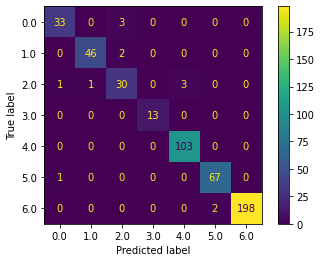

In [23]:
"""Confusion matrix to evaluate the classifier"""
y_pred=clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()